In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

### Import mamtorch library
To install mamtorch, in mamtorch root folder, "pip install ." (to improve compiling time, do this after installing ninja through "pip install ninja")

In [2]:
import mamtorch as mam

### Select the GPU
Currently, MAM kernels are implemented only for usage on GPU

In [3]:
# Select GPU
gpu_id = 0
# Check if the GPU is available, and if so, use it
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
# You need a gpu to use MAM kernel! (No cpu-based implementation available)
if(device == "cpu"):
    raise "No GPU device available! MAM kernels are not available."

### Define a simple feedforward DNN containing a MAM layer

In [4]:
# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleNN, self).__init__()
        # Instantiate a MAC fc layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        
        # Instantiate a MAM fc layer
        self.fc2_mam = mam.nn.FullyConnected(hidden_size1, hidden_size2, bias=True, vcon_steps=4, compute_exact=False) # set vanishing contributions steps to 4
        self.relu2 = nn.ReLU()
        
        # Instantiate the output layer
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2_mam(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
    
# Hyperparameters
input_size = 28 * 28  # MNIST image size
hidden_size1 = 512
hidden_size2 = 256
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

Load MNIST dataset and apply transformations

In [5]:
num_workers = 2 # increase this to use more threads to manage data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valtest_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
val_dataset, test_dataset = torch.utils.data.random_split(valtest_dataset, [0.5, 0.5], generator=torch.Generator().manual_seed(42))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Initialize the model, loss function, and optimizer

In [6]:
model = SimpleNN(input_size, hidden_size1, hidden_size2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train the network

In [7]:
# Initialize the selection matrix list.
# Here, for each training epoch, we store the number of times each interconnection has been used
# I.E., the selection count
selection_matrix_list = []

# Training loop
for epoch in range(num_epochs):
    start_time = time.perf_counter()
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    model.train() # se training mode

    correct = 0
    total = 0
    running_loss = 0
    total_step = len(train_loader)
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)  # Flatten the input images
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # evaluate the correct values agaist the total evaluated
        correct += (predicted == labels.to(device)).sum().item()
        total += labels.size(0)

        print(f'Training [{i + 1}/{total_step}], Loss: {running_loss/total:.3e}, Acc: {correct/total*100:.1f}%', end='\r')
    print(f'Training [{total_step}/{total_step}], Loss: {running_loss/total:.3e}, Acc: {correct/total*100:.1f}%')
    
    model.eval() # set evaluation mode
    
    # reset the selection count in the mam layer
    model.fc2_mam.reset_selection_count()
    
    correct = 0
    total = 0
    running_loss = 0
    total_step = len(val_loader)
    for images, labels in val_loader:
        images = images.view(-1, 28 * 28).to(device)  # Flatten the input images
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))
        
        running_loss += loss

        # update the selection count with the results of this batch
        model.fc2_mam.update_selection_count()
        
        # get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        # evaluate the correct values agaist the total evaluated
        correct += (predicted == labels.to(device)).sum().item()
        total += labels.size(0)

        print(f'Validation [{i + 1}/{total_step}], Loss: {running_loss/total:.3e}, Acc: {correct/total*100:.1f}%', end='\r')
    print(f'Validation [{total_step}/{total_step}], Loss: {running_loss/total:.3e}, Acc: {correct/total*100:.1f}%')
    
    # add evaluated selection count matrix to the list
    # (as the sum of the count of interconnections selected as maximum and as minimum)
    selection_matrix_list += [model.fc2_mam.max_selection_count + model.fc2_mam.min_selection_count]
    
    # update the value of beta for vanishing contributes
    model.fc2_mam.vcon_step()
    
    print(f"Elapsed time = {time.perf_counter()-start_time:.3f} s")
    
print("Training end.")

Epoch [1/10]
Training [938/938], Loss: 7.616e-03, Acc: 82.3%
Validation [79/79], Loss: 6.856e-03, Acc: 84.7%%
Elapsed time = 14.827 s
Epoch [2/10]
Training [938/938], Loss: 5.613e-03, Acc: 86.9%
Validation [79/79], Loss: 5.760e-03, Acc: 86.8%%
Elapsed time = 13.608 s
Epoch [3/10]
Training [938/938], Loss: 5.025e-03, Acc: 88.0%
Validation [79/79], Loss: 5.570e-03, Acc: 87.6%%
Elapsed time = 13.709 s
Epoch [4/10]
Training [938/938], Loss: 4.609e-03, Acc: 89.0%
Validation [79/79], Loss: 5.203e-03, Acc: 88.4%%
Elapsed time = 13.714 s
Epoch [5/10]
Training [938/938], Loss: 4.694e-03, Acc: 89.0%
Validation [79/79], Loss: 5.198e-03, Acc: 88.1%%
Elapsed time = 13.836 s
Epoch [6/10]
Training [938/938], Loss: 4.116e-03, Acc: 90.2%
Validation [79/79], Loss: 5.069e-03, Acc: 88.6%%
Elapsed time = 13.569 s
Epoch [7/10]
Training [938/938], Loss: 3.871e-03, Acc: 90.7%
Validation [79/79], Loss: 5.185e-03, Acc: 88.3%%
Elapsed time = 13.733 s
Epoch [8/10]
Training [938/938], Loss: 3.676e-03, Acc: 91.1%
V

In [8]:
# Test the model on the test dataset
model.eval() # set evaluation mode

correct = 0
total = 0
running_loss = 0
total_step = len(val_loader)
for images, labels in test_loader:
    images = images.view(-1, 28 * 28).to(device)  # Flatten the input images
    outputs = model(images)
    loss = criterion(outputs, labels.to(device))
    
    running_loss += loss
    
    # get the predicted class
    _, predicted = torch.max(outputs.data, 1)
    
    # evaluate the correct values agaist the total evaluated
    correct += (predicted == labels.to(device)).sum().item()
    total += labels.size(0)

    print(f'Test [{i + 1}/{total_step}], Loss: {running_loss/total:.3e}, Acc: {correct/total*100:.1f}%', end='\r')
print(f'Test [{total_step}/{total_step}], Loss: {running_loss/total:.3e}, Acc: {correct/total*100:.1f}%')

Test [79/79], Loss: 5.350e-03, Acc: 88.3%%


### Analysis on the interconnections
1) How many interconnections have been selected at least once for each training epoch?
2) How many times each interconnection has been selected as max/min for each training epoch?

In [9]:
# This analysis is performed on the validation dataset

legend_list = []
data_list = []

for i in range(num_epochs):
    selected_interconnections = int(torch.sum(selection_matrix_list[i]>0))
    total_interconnections = selection_matrix_list[i].shape[0]*selection_matrix_list[i].shape[1]
    print("Training epoch", i)
    print(f"Number of selected interconnections: {selected_interconnections} "
          f"({selected_interconnections/total_interconnections*100:.2f}%)")
    data_list += [np.histogram(selection_matrix_list[i].cpu().numpy().flatten(), bins=np.max(selection_matrix_list[i].cpu().numpy()))]
    legend_list += [f"epoch {i}"]

Training epoch 0
Number of selected interconnections: 27789 (21.20%)
Training epoch 1
Number of selected interconnections: 28774 (21.95%)
Training epoch 2
Number of selected interconnections: 28662 (21.87%)
Training epoch 3
Number of selected interconnections: 28404 (21.67%)
Training epoch 4
Number of selected interconnections: 16427 (12.53%)
Training epoch 5
Number of selected interconnections: 16009 (12.21%)
Training epoch 6
Number of selected interconnections: 15988 (12.20%)
Training epoch 7
Number of selected interconnections: 15531 (11.85%)
Training epoch 8
Number of selected interconnections: 15079 (11.50%)
Training epoch 9
Number of selected interconnections: 15293 (11.67%)


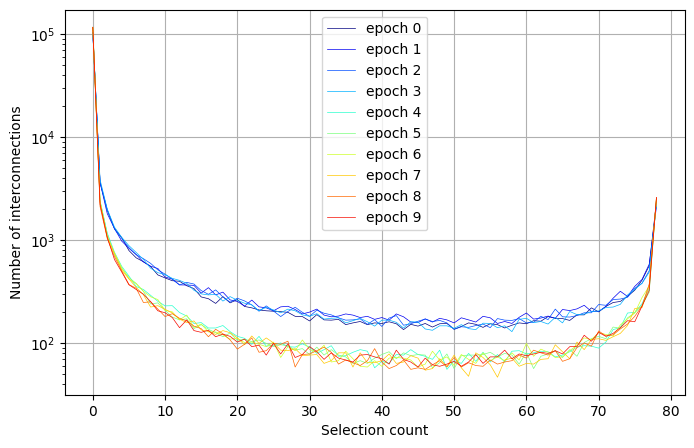

In [10]:
plt.figure(figsize=(8, 5))
cmap = plt.get_cmap('jet')
for i in range(num_epochs):
    plt.plot(data_list[i][1][:-1], data_list[i][0], linewidth=0.5, color=cmap(int(i/num_epochs*255)))
plt.grid()
plt.xlabel("Selection count")
plt.ylabel("Number of interconnections")
plt.yscale("log")
plt.legend(legend_list)
plt.show()

In [11]:
from torch.profiler import profile, record_function, ProfilerActivity

images = test_loader.dataset[batch_size][0].view(-1, 28 * 28).to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, with_stack=True) as prof:
    with record_function("model_inference"):
        outputs = model(images)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us       1.884ms        89.90%       1.884ms       1.884ms           0 b           0 b           0 b           0 